In [1]:
%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

In [2]:
mnist = input_data.read_data_sets("./data/", one_hot=True)

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz


In [20]:
def batch_norm_layer(inputs, is_training=None, name=None, decay=0.999, epsilon=1e-5):
    """
    Batch-Normalization Layer
    
    params
    ======
    - inputs: input Tensor
    - name(Optional): name of the layer
    - decay(Optional): decay rate of moving average of input moments
    - epsilon(Optional): epsilon to advoid dividing by 0.
    
    returns
    =======
    - is_training: a placeholder of type tf.bool. If the value is `True`, the
    layer will run in training phase, otherwise running in inference phase.
    - outputs: batch normalized outputs
    """
    if is_training is None:
        is_training = tf.placeholder(tf.bool, name="is_training")
    
    N_features = inputs.get_shape()[-1]
    scale = tf.Variable(tf.ones(N_features), dtype=tf.float32, name="scale")
    offset = tf.Variable(tf.ones(N_features), dtype=tf.float32, name="offset")
    
    moving_mean = tf.Variable(tf.zeros(N_features), 
                              trainable=False,
                              name="moving_mean")
    moving_vars = tf.Variable(tf.ones(N_features),
                              trainable=False,
                              name="moving_vars")
    inference_outputs = tf.nn.batch_normalization(inputs,
                                                  moving_mean,
                                                  moving_vars,
                                                  offset,
                                                  scale,
                                                  epsilon)
    fn_inference = lambda: inference_outputs
    
    # According to this issue https://github.com/tensorflow/tensorflow/issues/3287
    # I have to use nonlocal here, sorry about that....
    train_outputs = None
    def fn_training():
        inputs_mean, inputs_vars = tf.nn.moments(inputs, 1)
        update_mean_op = tf.assign(moving_mean, decay*moving_mean+(1-decay)*inputs_mean)
        update_vars_op = tf.assign(moving_vars, decay*moving_vars+(1-decay)*inputs_vars)
        
        nonlocal train_outputs # I know it's ugly....
        if train_outputs is None:
            train_outputs = tf.nn.batch_normalization(inputs, 
                                                      inputs_mean, 
                                                      inputs_vars,
                                                      offset,
                                                      scale,
                                                      epsilon)
        with tf.control_dependencies([update_mean_op, update_vars_op]):
            return tf.identity(train_outputs)
    
    outputs = tf.cond(is_training, 
                      true_fn=fn_training, 
                      false_fn=fn_inference, 
                      name=name)
    return outputs, is_training

In [21]:
graph = tf.Graph()
with graph.as_default():
    is_training = tf.placeholder(tf.bool)
    x_ = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])
    
    # layer 1
    W1 = tf.Variable(np.random.randn(784, 100), dtype=tf.float32)
    z1 = tf.matmul(x_, W1)
    a1, _ = batch_norm_layer(z1, is_training)
    l1 = tf.nn.sigmoid(a1)
    
    # layer 2
    W2 = tf.Variable(np.random.randn(100, 100), dtype=tf.float32)
    z2 = tf.matmul(l1, W2)
    a2, _ = batch_norm_layer(z2, is_training)
    l2 = tf.nn.sigmoid(a2)
    
    # layer 3
    W3 = tf.Variable(np.random.randn(100, 10), dtype=tf.float32)
    z3 = tf.matmul(l2, W3)
    y = tf.nn.softmax(z3)
    predict = tf.arg_max(y, 1)
    
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))
    train_op = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cross_entropy)

In [22]:
def comput_accuracy(y1, y2):
    return (y1 == y2).mean()

In [24]:
n_iterations = 40000
batch_size = 100

losses = [None for _ in range(n_iterations)]
accuracy = []

with tf.Session(graph=graph) as sess:
    tf.global_variables_initializer().run()
    
    for step in range(n_iterations):
        train_image, train_labels = mnist.train.next_batch(batch_size)
        feed_dict = { x_:train_image,
                      y_:train_labels,
                      is_training:True}
        _, l = sess.run([train_op, cross_entropy], feed_dict=feed_dict)
        losses[step] = l
        if (step+1) % 1000 == 0:
            feed_dict[x_] = mnist.test.images
            feed_dict[y_] = mnist.test.labels
            feed_dict[is_training] = False
            pred = sess.run(predict, feed_dict=feed_dict)
            acc = comput_accuracy(pred, np.argmax(mnist.test.labels, 1))
            accuracy.append(acc)
            print("Iteration {}: {} {:.2f}".format(step+1, l, acc))

Iteration 1000: 28.186695098876953 0.90
Iteration 2000: 22.22321128845215 0.93
Iteration 3000: 29.63637924194336 0.93
Iteration 4000: 27.688053131103516 0.94
Iteration 5000: 16.16019058227539 0.95
Iteration 6000: 10.750244140625 0.95
Iteration 7000: 12.212532043457031 0.96
Iteration 8000: 9.809295654296875 0.96
Iteration 9000: 10.357383728027344 0.96
Iteration 10000: 10.009647369384766 0.96
Iteration 11000: 3.888364553451538 0.96
Iteration 12000: 16.899858474731445 0.96
Iteration 13000: 4.445891380310059 0.96
Iteration 14000: 2.782381057739258 0.96
Iteration 15000: 4.800086498260498 0.97
Iteration 16000: 12.765398025512695 0.96
Iteration 17000: 3.614741802215576 0.97
Iteration 18000: 6.137696266174316 0.97
Iteration 19000: 3.7870848178863525 0.97
Iteration 20000: 8.472077369689941 0.96
Iteration 21000: 1.2689847946166992 0.97
Iteration 22000: 7.817301273345947 0.97
Iteration 23000: 6.524452209472656 0.97
Iteration 24000: 3.805023193359375 0.97
Iteration 25000: 2.06154465675354 0.97
Ite

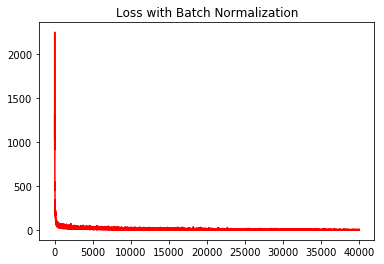

In [27]:
plt.title("Loss with Batch Normalization")
plt.plot(losses, "r-")

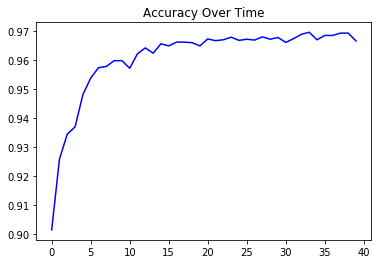

In [28]:
plt.title("Accuracy Over Time")
plt.plot(accuracy, "b-")